<a href="https://colab.research.google.com/github/nivedphil/Stock-price-predictor/blob/main/LSTM_Stock_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Assuming the dataset is in a CSV format
df = pd.read_csv('/content/stock_price.csv')

# Display the first few rows
print(df.head())

# Check for data types and missing values
print(df.info())

# Summary statistics
print(df.describe())


          日付け     終値     始値     高値     安値      出来高   変化率 %
0  2024-08-01  156.3  159.3  159.4  156.1   79.15M  -2.56%
1  2024-07-31  160.4  158.2  160.7  158.1  173.91M   1.07%
2  2024-07-30  158.7  158.8  159.2  158.0  138.14M  -0.63%
3  2024-07-29  159.7  158.7  160.2  158.4  126.28M   1.14%
4  2024-07-26  157.9  159.3  159.6  157.9  155.08M  -0.13%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日付け     9202 non-null   object 
 1   終値      9202 non-null   float64
 2   始値      9202 non-null   float64
 3   高値      9202 non-null   float64
 4   安値      9202 non-null   float64
 5   出来高     9202 non-null   object 
 6   変化率 %   9202 non-null   object 
dtypes: float64(4), object(3)
memory usage: 503.4+ KB
None
                終値           始値           高値           安値
count  9202.000000  9202.000000  9202.000000  9202.000000
mean     92.180961    92.256183 

In [2]:
reference = {"Date": "日付け", "Close": "終値", "Open": "始値", "High": "高値", "Low": "安値", "Volume": "出来高", "Return": "変化率 %"}

In [3]:
# Convert Date column to datetime format
df['日付け'] = pd.to_datetime(df['日付け'], format='%Y-%m-%d')

# Set '日付け' as the index
df.set_index('日付け', inplace=True)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


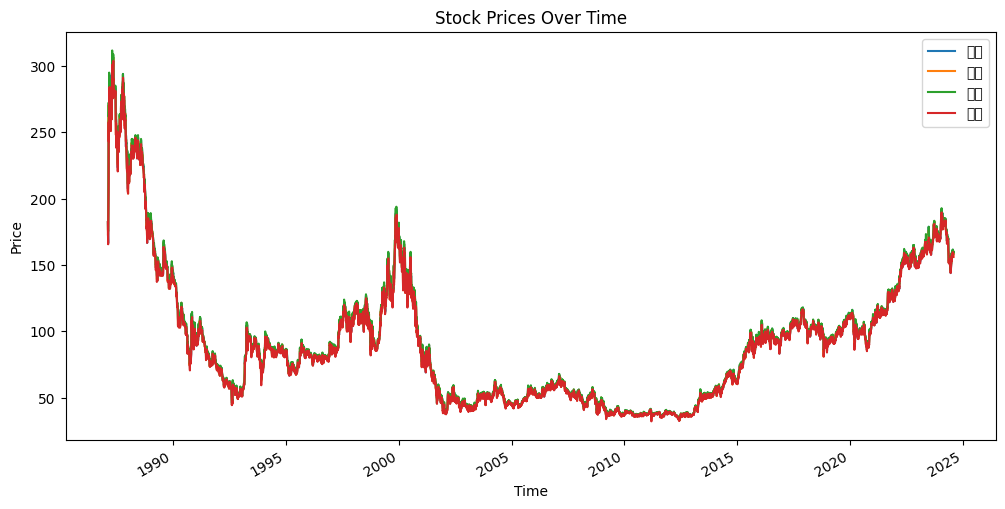

In [4]:
import matplotlib.pyplot as plt

# Plotting the Open, Close, High, Low values
df[['始値', '終値', '高値', '安値']].plot(figsize=(12,6))
plt.title('Stock Prices Over Time')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()


In [5]:
for i in range(9202):
    df['出来高'][i] = float(df['出来高'][i][:-1])
    df[reference["Return"]][i] = float(str(df[reference["Return"]][i])[:-1])

Streaming output truncated to the last 5000 lines.
<ipython-input-5-4acb4285f073>:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['出来高'][i] = float(df['出来高'][i][:-1])
<ipython-input-5-4acb4285f073>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[reference["Return"]][i] = float(str(df[reference["Return"]][i])[:-1])
<ipython-input-5-4acb4285f073>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will 

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping


In [7]:
sc = MinMaxScaler(feature_range=(0, 1))
trainData = sc.fit_transform(df[[reference['Close']]].values[:9000])
trainData.shape

(9000, 1)

In [8]:
testData = sc.transform(df[[reference['Close']]].values[9000:])
testData.shape

(202, 1)

In [11]:

X_train = []
Y_train = []
for i in range(60, 9000):
    X_train.append(trainData[i-60:i])
    Y_train.append(trainData[i])
X_test = []
Y_test = []
for i in range(60, 202):
    X_test.append(testData[i-60:i])
    Y_test.append(testData[i])


In [12]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(8940, 60, 1)

In [14]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model (same as before)
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,101 (1.08 MB)

 Trainable params: 282,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(X_train, Y_train, epochs=25, batch_size=16,
          validation_split=0.2,  # Use 20% of training data as validation set
          callbacks=[early_stopping])


Epoch 1/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 2/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 9.7778e-04 - val_loss: 6.1325e-04
Epoch 3/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.6966e-04 - val_loss: 0.0016
Epoch 4/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 5.5762e-04 - val_loss: 5.2457e-04
Epoch 5/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 5.5471e-04 - val_loss: 0.0021
Epoch 6/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 6.1646e-04 - val_loss: 3.0659e-04
Epoch 7/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 4.9635e-04 - val_loss: 2.9656e-04
Epoch 8/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.7283e-04 - val_loss: 0.0017
Epoch 9/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 4.5598e-04 - val_loss: 4.9431e-04
Epoch 10/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 4.0745e-04 - val_loss: 2.0510e-04
Epoch 11/25
447/447 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss:

In [17]:
X_test = np.array(X_test)


In [18]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(142, 60, 1)

In [19]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


In [20]:
from sklearn.metrics import r2_score

r2_score(Y_test, y_pred)

0.8165202140808105

In [21]:
predicted_price = sc.inverse_transform(y_pred)

In [22]:
actual_price = sc.inverse_transform(Y_test)

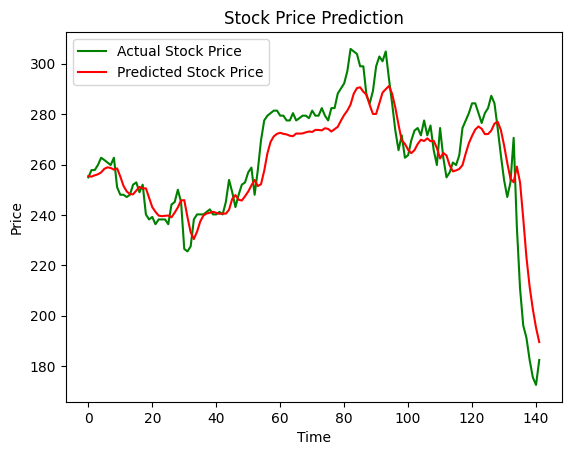

In [23]:
plt.plot(actual_price, color='green', label='Actual Stock Price')
plt.plot(predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

In [24]:
model.save('stock_price_predictions_best.keras')

In [ ]:
from keras.models import load_model

model = load_model('stock_price_predictions_ver2.keras')